In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import example_utils as ex_utils

import MARBLE
from MARBLE import plotting, dynamics, geometry

# For initial conditions, sample a rectangle uniformly

In [2]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [38]:
n_mus = 30
mu = np.linspace(-2, 2, n_mus)

pos, vel = [], []
X0_range = dynamics.initial_conditions(n, len(mu), area)
for X0, m in zip(X0_range, mu):
    p, v = dynamics.simulate_vanderpol(m, X0, t)
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))

pos, vel = dynamics.embed_parabola(pos, vel)

/Users/arnaudon/base/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Plot vector fields

In [39]:
data = MARBLE.construct_dataset(pos, features=vel, graph_type='cknn', k=20, stop_crit=0.03, vector=True)

---- Embedding dimension: 3
---- Signal dimension: 3



Computing tangent spaces...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 610.18it/s]



Fraction of variance explained:  tensor([0.5899, 1.0000, 1.0000])

---- Manifold dimension: 2


Computing connections...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 154.33it/s]



---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


In [5]:
#titles = [r'$\beta$ = {:0.2f}'.format(m) for m in mu]

#axes = plotting.fields(data, col=4, alpha=1, width=7, scale=2, titles=titles, view=[70,20])
#for ax in axes:
#    ex_utils.plot_parabola(ax)

#plt.savefig('./outputs/parabolas.svg')

# Train network

In [40]:
par = {'epochs': 50, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 5,
       'inner_product_features': True,
      }

model = MARBLE.net(data, par=par)
model.run_training(data)


---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
dim_man : 2
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  450

---- Training network ...

Epoch: 1, Training loss: 1.377917, Validation loss: 1.3759, lr: 0.0100 *
Epoch: 2, Training loss: 1.364660, Validation loss: 1.3535, lr: 0.0100 *
Epoch: 3, Training loss: 1.337956, Validation loss: 1.3457, lr: 0.0100 *
Epoch: 4, Training loss: 1.326750, Validation loss: 1.3383, lr: 0.0100 *
Epoch: 5, Training loss: 1.306509, Validation loss: 1.3150, lr: 0.0100 *
Epoch: 6, Training loss: 1.296405, Validation loss: 1.3566, lr: 0.0100
Epoch: 7, Training loss: 1.285272, Validation loss: 1.2351, lr: 0.0100 *
Epoch

In [41]:
data = model.evaluate(data)
data = MARBLE.cluster_embeddings(data)

Performed umap embedding on embedded results.


Performed umap embedding on embedded results.


<Axes: >

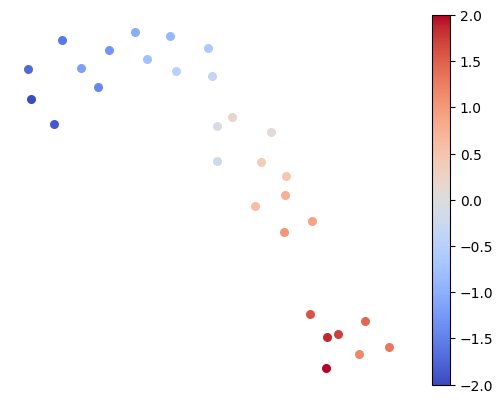

In [42]:
emb_MDS, _ = geometry.embed(data.dist)
plotting.embedding(emb_MDS, mu, s=30, alpha=1)

# Distance matrix

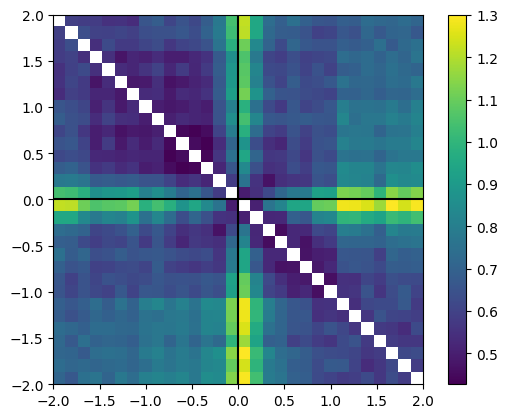

In [43]:
d= data.dist.copy()
d += np.diag(np.diag(d)*np.nan)
im = plt.imshow(d, extent=[mu[0], mu[-1], mu[0], mu[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')

plt.colorbar(im)

# Cluster and visualise embedding

<Axes: >

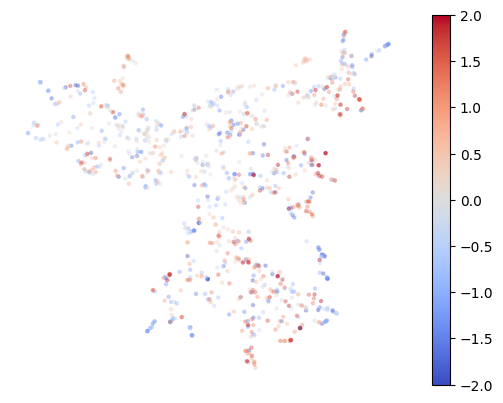

In [44]:
titles = [r'$\beta$ = {:0.2f}'.format(m) for m in mu]
plotting.embedding(data, mu[data.y.numpy().astype(int)])#, titles=titles)